In [1]:
# full import 

# data handling/loading 
import numpy as np
import pandas as pd
from sklearn import datasets
from scipy.spatial.transform import Rotation

np.random.seed(42)

# plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import MDS

# pipelines/tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# model
from sklearn.linear_model import LogisticRegression

# others
import time

In [2]:
# many Machine Learning problems involve thousands or even millions of features for each training instance
# not only does this make training extremely slow, it can also make it much harder to find a good solution
# this problem is often referred to as the 'curse of dimensionality'

# fortunately, in real-world problems, it is often possible to reduce the number of features considerably
# turning an intractable problem into a tracable one

# apart from speeding up training, dimensionality reduction is also extremely useful for data visualization (or DataViz)
# reducing the number of dimensions down to two or three makes it possible 
# to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights 
# by visually detecting patterns, such as clusters
# moreover, DataViz is essential to communicate your conclusion to people who are not data scientists
# in particular decision makers who will use your results

In [3]:
# in this chapter:
# we will discuss the curse of dimensionality and get a sense of what goes on in high-dimensional space
# we will present the two main approaches to dimensionality reduction:
#   # projection
#   # Manifold learning
# we will go through three of the most popular dimensionality reduction techniques:
#   # PCA
#   # Kernel PCA
#   # LLE

# The Curse of Dimensionality


We are so used to live in three dimensions that our intuition fails us when we try to imagine a high-dimensional space.


It turns out that many things behave very differently in high-dimensional space:
- For example, if you pick a random point in a 2D square, it will have only abou 0.4% chance of being located less than 0.001 from a border.
- But in a 10000-dimensional hypercube, this probability is greater than 99.999999%.
- Most points in a high-dimensional hypercube are very close to the border.


Here is a more troublesome difference:
- If you pick 2 points randomly in a 2D square, their average distance will be 0.52.
- If you pick 2 points randomly in a 1000000D hypercube, their average distance will be 408.25.
- This fact implies that high dimensional datasets are at risk of being very sparse.
- This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they based on much larger extrapolations.


In short, the more dimension the training set has, the greater the risk of overfitting it.


In theory, one solution to the curse of dimensionality is:
- Increase the size of the training set to reach a sufficient density of training instances. 
- Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.
    - With just 100 features (much less than the MNIST problem), you could need more training instances than atoms in the observable universe in order for training instaces to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

--- 

# Main Approaches for Dimensionality Reduction


Before we dive into specific dimensionality reduction algorithms, let's take a look at the two main approaches to reducing dimensionality:
- Projection.
- Manifold Learning.

---

## Projection


In most real world problems, training instances are *not* spread out uniformly across all dimensions.
- Many features are almost constant, while others are highly correlated.
- As a result, all training instances actually lie within (or close to) a much lower-dimensional *subspace* of the high-dimensional space.

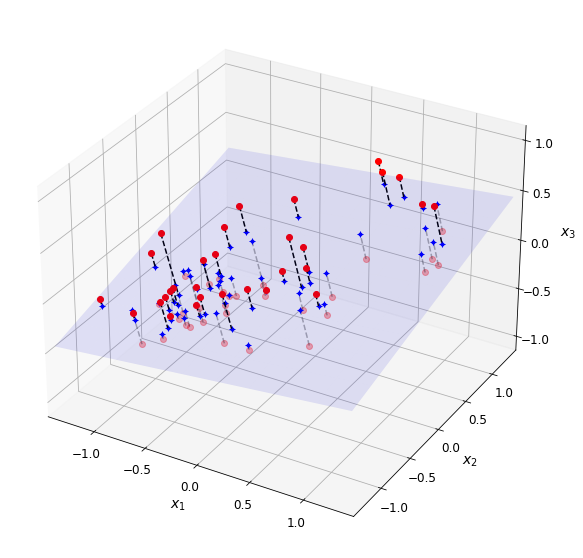

In [4]:
# this figure plot a 3D dataset represented by the circles
# notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial.transform import Rotation

# create a simple 3D dataset
m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10), np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

# create figure/axes
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k--", alpha=0.3)

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])
    
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
set_xyz_axes(ax, axes)

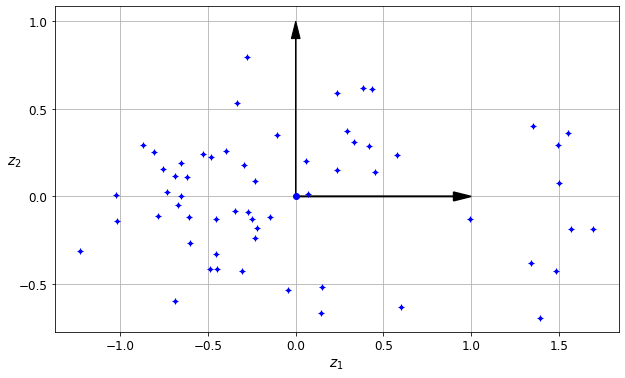

In [5]:
# if we project every training instance perpendicularly onto this subspace (as represented by the short lines connecting the instances to the plane)
# we get the new 2D dataset shown in this figure
# note that the axes correspond to new features z1 and z2 (the coordinates of the projections on the plane)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k', linewidth=1.5)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
_ = ax.grid(True)

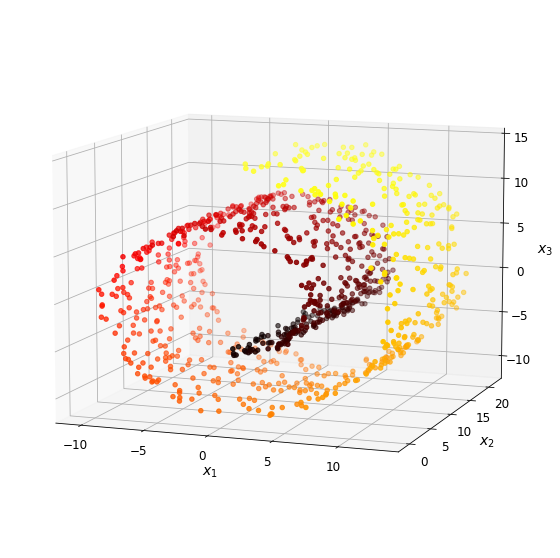

In [6]:
# however, projection is not always the best approach to dimensionality reduction
# in many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset

from matplotlib.colors import ListedColormap
from sklearn import datasets

X_swiss, t = datasets.make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)

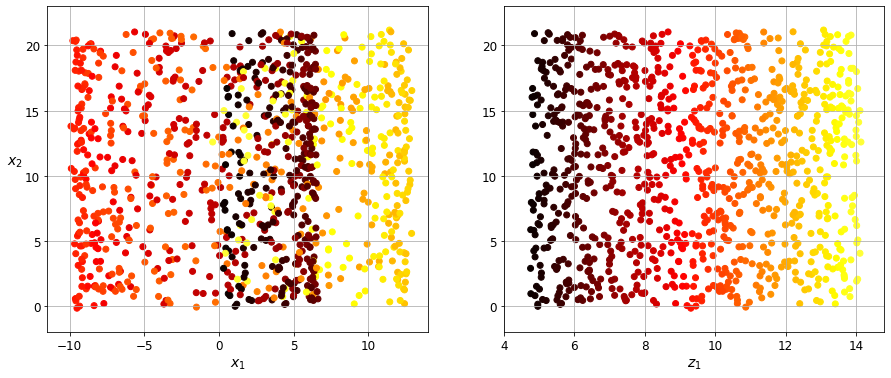

In [7]:
# simply projecting onto a plane (e.g. by dropping x3)
# would squash different layers of the Swiss roll together, as shown on the left plot
# however, what you really want is to unroll the Swiss roll to obtain the 2D dataset on the right

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
_ = plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
_ = plt.grid(True)

## Manifold Learning


The Swiss roll is an example of a 2D **manifold**:
- A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space.
- More generally, a $d$-dimensional manifold is a part of an $n$-dimensional space (where $d < n$) that locally resembles a $d$-dimensional hyperplane.
- In the case of a Swiss roll, $d = 2$ and $n = 3$: it locally resembles a 2D plane, but it is rolled in the third dimension.


Many dimensionality reduction algorithm work by modeling the **manifold** on which the training instances lie; this is called **Manifold Learning**.
- It relies on the **manifold assumption**, also called the **manifold hypothesis**, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold.
- This assumption is very often emprirically observed.


The manifold assumption is often accompanied by another implicit assumption:
- That the task at hand will be simpler if expressed in the lower-dimensional space of the manifold.
- However, this assumption does not always hold.
- In short, if you reduce the dimensionality of your training set before training a model it will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

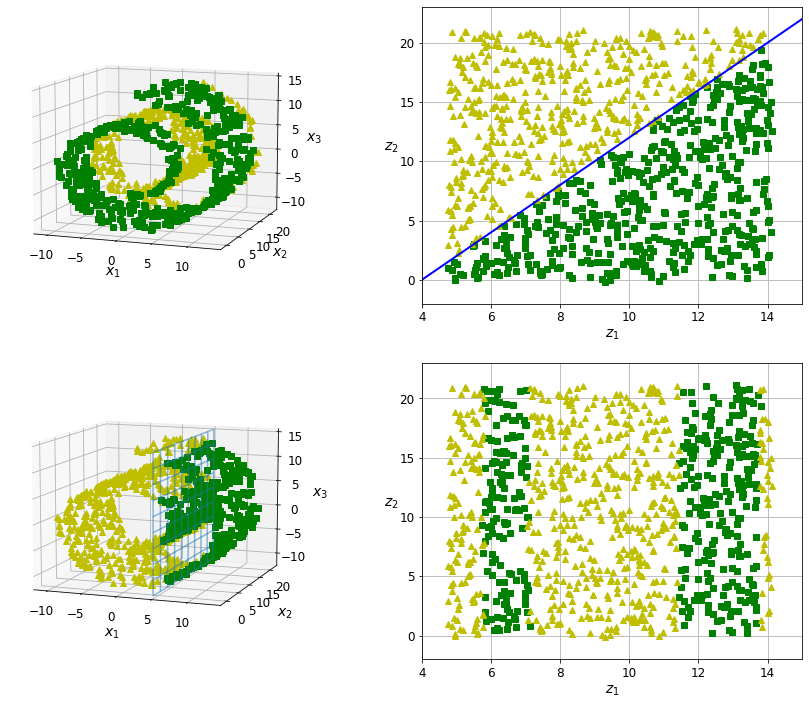

In [8]:
# this figure demonstrate that reducing the dimensionality of your training set doesn't always translate to more simpler solution
# in the top row:
#   # in the 3D space, the decision boundary would be fairly complex
#   # in the 2D space, the decision boundary is a simple straight line
# in the bottom row:
#   # in the 3D space, the decision boundary would looks very simple (a vertical plane)
#   # in the 2D space, the decision boundary would be fairly complex (a collection of 4 independent line segments)


axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(15, 12))

# bottom left
ax = plt.subplot(2, 2, 3, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)

# bottom right
ax = plt.subplot(2, 2, 4)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)


positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

# top left
ax = plt.subplot(2, 2, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# top right
ax = plt.subplot(2, 2, 2)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)


# PCA


**Principle Component Analysis** (**PCA**) is by far the most popular dimensionality reduction algorithm:
- First it identifies the hyperplane that lies closest to the data.
- Then it projects the data onto it.

---

## Preserving the Variance


Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane.

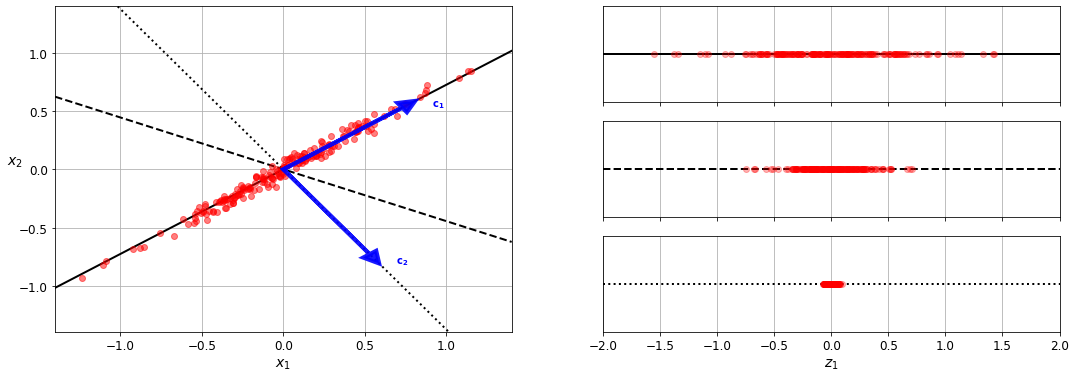

In [9]:
# this figure represent a simple 2D dataset
# along with 3 different axes (i.e. one-dimensional hyperplanes)
# on the right is the result of the projection of the dataset onto each of these axes

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)], [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(18, 6))

plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-", linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--", linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:", linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9, length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=4, alpha=0.9, length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

# as you can see, the projection onto the solid line preserves the maximum variance
# while the projection onto the dotted line preserves very little variance
# and the projection onto the dashed line preserves an intermediate amount of variance

# it seems reasonable to select the axis that preserves the maximum amount of variance
# as it will most likely lose less information than the other projection
# another way to justify this choice is that 
# it is the axis that maximizes the mean squared distance between the original dataset and its projection onto that axis
# this is the rather simple idea behind PCA

## Principal Components


PCA identifies the axis that accounts for the largest amount of variance in the training set:
- The unit vector that defines the $i^{th}$ axis is called the $\bold{i^{th}}$ **principal component** (PC).


So how can you find the principal components of a training set?
- There is a standard matrix factorization technique called **Single Value Decomposition** (SVD).
- This technique can decompose the training set matrix $\bold{X}$ into the matrix multiplication of three matrices $\bold{U}\Sigma\bold{V}^T$.
    - Where $\bold{V}^T$ contains all the principal components that we are looking for.


Principal components matrix:
> $\bold{V} = \begin{pmatrix} \vert & \vert & & \vert \\ \bold{c_1} & \bold{c_2} & ... & \bold{c_n} \\ \vert & \vert & & \vert \end{pmatrix}$


**Note**:
- PCA assumes that the dataset is centered around the origin.
- As we will see, Scikit-Learn's PCA classes take care of centering the data for you.
- However, if you implement PCA yourself, or if you use other libraries, don't forget to center the data first.

In [10]:
# the following python code uses numpy's svd() function to obtain all the principal components of the training set
# then extracts the first two PCs

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

## Projecting Down to $d$ Dimensions


Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimensions by:
- Projecting it onto the hyperplane defined by the first $d$ principal components.
- Selecting this hyperplane ensures that the projection will preserve as much variance as possible.


To project the training set onto the hyperplane:
- You can simply compute the matrix multiplication of the training set matrix $\bold{X}$ by the matrix $\bold{W}_d$.


Projecting the training set down to d dimensions
> $\bold{X}_{d-\text{proj}}=\bold{X}\bold{W}_d$


**Notations**:
- $\bold{W}_d$: is the matrix containing the first $d$ principal components (i.e. the matrix composed of the first $d$ columns of $\bold{V}$).

In [11]:
# the following python code projects the training set onto the plane defined by the first two principal components
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

## Using Scikit-Learn


Scikit-Learn's `PCA` class implements PCA using SVD decomposition just like we did before.

In [12]:
# the following python code applies PCA to reduce the dimensionality of the dataset down to 2 dimensions
# note that it automatically takes care of centering the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [13]:
# after using the PCA transformer to the dataset
# you can access the principal components using the `components_` attribute

# note that it contains the PCs as horizontal vectors
# so, for example, the first principal component is
pca.components_.T[:, 0]

array([0.67857588, 0.70073508, 0.22023881])

## Explained Variance Ratio


Another very useful piece of information is the **explained variance ratio** of each principal component:
- Available via the `explained_variance_ratio_` attribute.
- It indicates the proportion of the dataset's variance that lies along the axis of each principal component

In [14]:
# for example, let's look at the explained variance ratios of the first two components of the 3D dataset above
pca.explained_variance_ratio_

# this tells you that 75.7% of the dataset's variance lies along the first axis
# and 15.1% of the dataset's variance lies along the second axis
# this leaves 9.2% for the third axis, so it is reasonable to assume that it probably carries little information

array([0.7578477 , 0.15186921])

## Choosing the Right Number of Dimensions


Instead of arbitrarily choosing the number of dimensions to reduce down to:
- It is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance.
- Unless you are reducing dimensionality for data visualization - in that case you will generally want to reduce the dimensionality down to 2 or 3.

In [15]:
# the following code computes PCA without reducing dimensionality 
# then computes the number of dimensions required to preserve 95% of the training set's variance

mnist = datasets.fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

d

154

In [16]:
# you could then set 'n_components=d' and run PCA again
# however, there is a much better option:
#   # instead of specifying the number of principal components you want to preserve
#   # you can set n_components to be a float between 0.0 and 1.0
#   # indicating the ratio of variance you wish to preserve

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

154

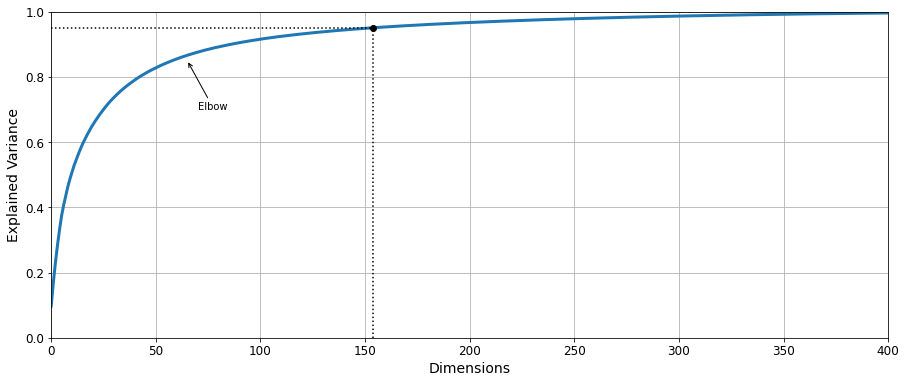

In [17]:
# yet another option is to plot the explained variance as a function of the number of dimensions (simply plot cumsum)

plt.figure(figsize=(15, 6))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"))
_ = plt.grid(True)

# there will usually be an elbow in the curve where the explained variance stops growing fast
# you can think of this as the intrinsic dimensionality of the dataset
#   # in this case, you can see that reducing the dimensionality down to about 100 dimensions wouldn't lose too much explained variance

## PCA for Compression


Obviously, after dimensionality reduction, the training set takes up much less space.
- For example:
    - Try applying PCA to the MNIST dataset while preserving 95% of its variance.
    - You should find that each instance will have just over 150 features, instead of the original 784 features.
    - So while most of the variance is preserved, the dataset is now less than 20% its original size!
    - This is a reasonable compression ratio, and you can see how this can speed up a classification algorithm (such as SVM classifier) tremendously.


It is also possible to decompress the reduced dataset back to 784 dimensions:
- By applying the inverse transformation of the PCA projection.
- Of course this won't give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be quite close to the original data.
- The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called **reconstruction error**.


PCA inverse transformation, back to the original number of dimensions:
> $\large\bold{X}_\text{recovered}=\bold{X}_{d-\text{proj}}{\bold{W}_d}^T\normalsize$

In [18]:
# the following code compresed the MNIST dataset down to 154 dimensions
# then uses the inverse_transform() method to decompress it back to 784 dimensions

pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

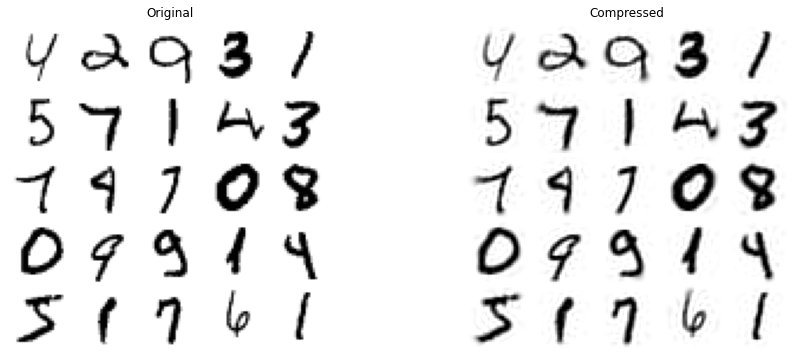

In [19]:
# this figure shows a few digit from the original dataset (left)
# and the corresponding digits after compression and decompression (right)
# you can see that there is a slight image quality loss, but the digits are still mostly intact

plt.figure(figsize=(15, 6))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

## Randomized PCA


If you set the `svd_solver` hyperparameter to `randomized`, Scikit-learn uses a stochastic algorithm called **Randomized PCA** that quickly finds an approximation of the first $d$ principal components.
- It computational complexity is $O(m\times d^2) +O(d^3)$, instead of $O(m\times n^2) + O(n^3)$ for the full SVD approach.
- So it is dramatically faster than full SVD when $d$ is much smaller than $n$.
- By default, `svd_solver` is actually set to `auto`:
    - Scikit-Learn automatically uses the randomized PCA algorithm if $m$ or $n$ is greater than 500 and $d$ is less than 80% of $m$ or $n$.
    - Or else it uses the full SVD approach.
    - If you want to force Scikit-Learn to use full SVD, you can set the `svd_solver` hyperparameter to `full`.

In [20]:
# set svd_solver='randomized' to use Randomized PCA

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA


One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run.
- Fortunately, **Incremental PCA** (**IPCA**) algorithms have been developed:
    - You can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.
    - This is useful for large training sets, and also to apply PCA online (i.e. on the fly, as new instances arrive).

In [21]:
# the following code splits the MNIST dataset into 100 mini-batches (using numpy's array_split() function)
# and feeds them to Scikit-Learn's IncrementalPCA class to reduce the dimensionality of the MNIST dataset down to 154 dimensions
# note:
#   # you must call the partial_fit() method with each mini-batch 
#   # rather than the fit() method with the whole training set

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [22]:
# alternatively, you can use numpy's 'memmap' class
# which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory
# the class loads only the data it needs in memory, when it needs it
# since the IncrementalPCA class uses only a small part of the array at any given time
# the memory usgae remains under control
# this makes it possible to call the fit() method, as you can see in the following code


# first, let's create a memmap() structure
# copy the MNIST training set into it
# and call flush() which ensures that any data still in cache is saved to disk
filename = "datasets/my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

In [23]:
# next, another program would load the data and use it for training

X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

## Time Complexity


This part is extra materials. We will now compare **PCA** with **Incremental PCA** and **Randomized PCA**.


**Note**: The following block of codes may take several minutes to run.

In [24]:
# Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

import time

n = len(X_train) // 2 # to reduce time 
print("number of instances:", n)

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train[:n])
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

number of instances: 30000
n_components = 2
    PCA: 7.6 seconds
    Inc PCA: 14.4 seconds
    Rnd PCA: 1.4 seconds
n_components = 10
    PCA: 7.1 seconds
    Inc PCA: 13.9 seconds
    Rnd PCA: 2.6 seconds
n_components = 154
    PCA: 8.2 seconds
    Inc PCA: 20.2 seconds
    Rnd PCA: 5.1 seconds


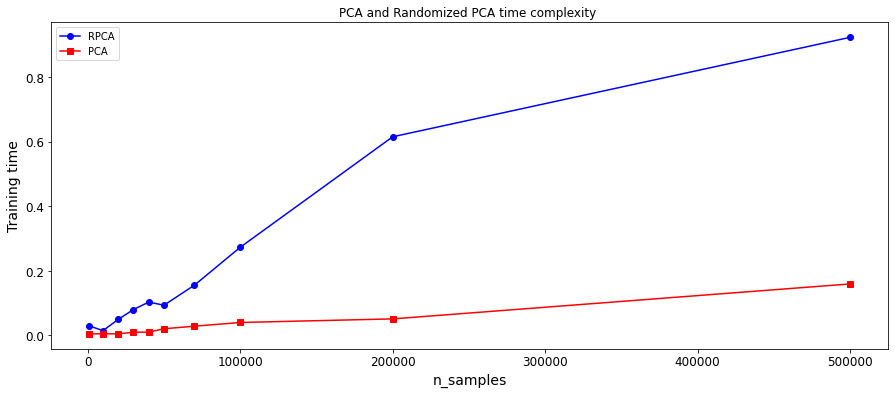

In [25]:
# Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(15, 6))
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
_ = plt.title("PCA and Randomized PCA time complexity ")

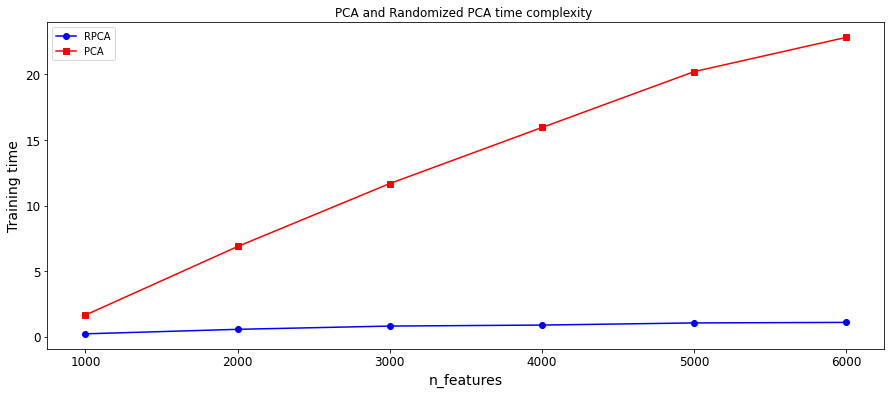

In [26]:
# And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(15, 6))
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
_ = plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA


In chapter 5, we discussed the kernel trick: 
- A mathematical technique that implicitly maps instances into a very-high dimensional space (called **feature space**).
- Enabling nonlinear classification and regression with Support Vector Machines.
- Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the **original space**.


It turns out that the same trick can be applied to PCA:
- Making it possible to perform complex nonlinear projections for dimensionality reduction.
- This is called **Kernel PCA** (**kPCA**).
- It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

In [27]:
# for example, this following code uses sklearn's KernelPCA class to perform kPCA with an RBF kernel

from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

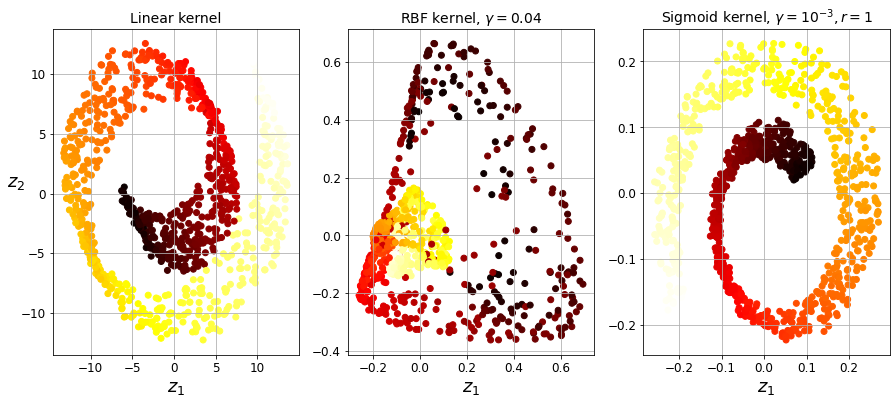

In [28]:
# this code shows the swiss roll, reduce to two dimensions:
#   # using a linear kernel (equivalent to using the PCA class)
#   # using an RBF kernel
#   # using a sigmoid kernel (Logistic)

X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(15, 6))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

## Select a Kernel and Tuning Hyperparameters


As kPCA is an unsupervised learning algorithm, there is no obvious performance measure to help you select the best kernel and hyperparameter values.
- However, dimensionality reduction is often a preparation step for a supervised learning task.
- So you can simply use grid search to select the kernel and hyperparameters that lead to the best performance on that task.

---

Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters that yield the lowest reconstruction error.
- Note that reconstruction is not as easy as with linear PCA. Here's why: ($\color{red}\bold{\text{read book to see image}}$).
- The figure shows the Swiss roll 3D dataset (top left) and the resulting 2D dataset after kPCA is applied using an RBF kernel (top right).
- Thanks to the kernel trick, this transformation is mathematically equivalent to using the **feature map** $\varphi$ to map the training set to an infinite-dimensional feature space (bottom right), then projecting the transformed training set down to 2D using linear PCA.
- Notice that if we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in the feature space, not in the original space (e.g. like the one represented by an **x** in the diagram).
- Since the feature space is infinite-dimensional, we cannot compute the reconstructed point, and therefore we cannot compute the true reconstruction error.
- Fortunately, it is possible to find a point in the original space that would map close to the reconstructed point.
    - This point is called the reconstruction **pre-image**.
- Once you have this pre-image, you can measure its squared distance to the original instance.
- You can then select the kernel and hyperparameters that minimize this construction pre-image error.


You may wondering how to perform this reconstruction:
- One solution is to train a supervised regression model.
    - With the projected instances as the training set.
    - And the original instances as the targets.
- Scikit-Learn will do this automatically if you set `fit_inverse_transform=True`.

In [29]:
# the following code creates a two steps pipeline
# first reducing dimensionality to two dimensions using kPCA
# then applying Logistic Regression for classification
# then it uses GridSearchCV to find the best kernel and 'gamma' value for kPCA 
# in order to get the best classification accuracy at the end of the pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [30]:
# the best kernel and hyperparameters are then available through the 'best_params_' attribute

grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [31]:
# the following code perform reconstruction using pre-image reconstruction

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [32]:
# you can then compute the reconstruction pre-image error
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

# now you can use grid search with cross-validation to find the kernel and hyperparameters that minimize this error

32.786308795766125

# LLE


**Locally Linear Embedding** (**LLE**) is another powerful **nonlinear dimensionality reduction** (NLDR) technique.
- It is a Manifold Learning technique that does not rely on projections, like the previous algorithms do.
- LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.).
- Then looking for a low-dimensional representation of the training set where these local relationships are best preserved.
- This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.


Here's how LLE works:
- For each instance $\bold{x}^{(i)}$: 
    - The algorithm identifies its $k$ closest neighbors
    - Then tries to reconstruct $\bold{x}^{(i)}$ as a linear function of these neighbors.
- More specifically, it finds the weights $w_{i,j}$ such that:
    - The squared distance between $\bold{x}^{(i)}$ and $\sum_{j=1}^mw_{i,j}\bold{x}^{(j)}$ is as small as possible.
    - Assuming $w_{i,j} = 0$ if $\bold{x}^{(j)}$ is not one of the $k$ closest neighbors of $\bold{x}^{(i)}$.
- Thus the first step of LLE is the constrained optimization problem described in the following equation.


LLE step one: linearly modelling local relationships
> $\large\widehat{\bold{W}}= \argmin\limits_\bold{W} \displaystyle\sum_{i=1}^m\left(x^{(i)} - \sum_{j=1}^mw_{i,j}\bold{x}^{(j)}\right)^2 \\ \text{subject to} \begin{cases}w_{i,j}=0 & \text{if }\  x^{(j)} \text{ is not one of the } k \text{ c.n. of } x^{(i)} \\ sum_{j=1}^mw_{i,j}=1 & \text{for } i = 1,2,...,m \end{cases}\normalsize$


- After this step, the weight matrix $\widehat{\bold{W}}$ (contraining the weights $\hat{w}_{i,j}$) encodes the local linear relationships between the training instances.
- The second step is to map the training instances into a $d$-dimensional space (where $d<n$) while preserving these local relationships as much as possible.
- If $\bold{Z}^{(i)}$ is the image of $\bold{X}^{(i)}$ in this $d$-dimensional space, then we want the squared distance between $\bold{z}^{(i)}$ and $\sum_{j=1}^m\hat{w}_{i,j}\bold{z}^{(j)}$ to be as small as possible.
- This idea leads to the constrained optimization problem described in the following equation.
    - It looks very similar to the first step, but instead of keeping the instances fixed and finding the optimal weights.
    - We are doing the reverse, keeping the weights fixed and finding the optimal position of the instances' images in the low-dimensional spcace.


LLE step two: reducing dimensionality while preserving relationships:
> $\large\widehat{\bold{Z}} = \argmin\limits_\bold{Z}\displaystyle\sum_{i=1}^m\left(\bold{z}^{(i)} - \sum_{j=1}^m\hat{w}_{i,j}\bold{z}^{(j)}\right)^2\normalsize$


**Notations**:
- $\bold{Z}$: is the matrix containing all $\bold{z}^{(i)}$.

---

Scikit-Learn's LLE has the following computational complexity:
- $O(m\log(m)n\log(k))$ for finding the $k$ nearest neighbors.
- $O(mnk^3)$ for optimizing the weights.
- $O(dm^2)$ for constructing the low-dimensional representations.
- Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very large datasets.

In [33]:
# the following code uses sklearn's LocallyLinearEmbedding class to unroll the Swiss roll

from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = datasets.make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

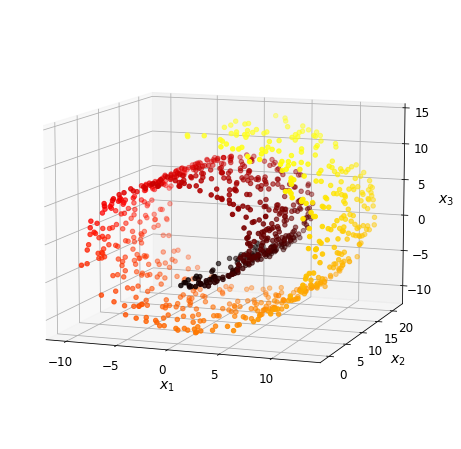

In [34]:
# plot the Swiss roll in 3D form

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)

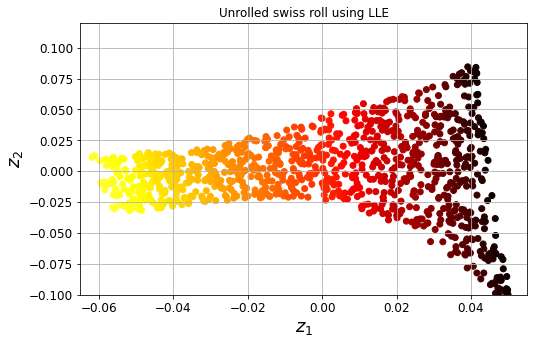

In [35]:
# this figure plots the result of the preceding code

plt.figure(figsize=(8, 5))
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap=darker_hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
_ = plt.title("Unrolled swiss roll using LLE")


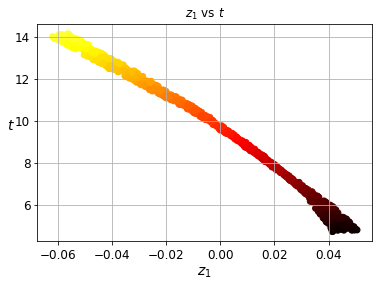

In [36]:
# extra code – shows how well correlated z1 is to t: LLE worked fine

plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

# Other Dimensionality Reduction Techniques 


There are many other dimensionality reduction techniques, several of which are available in Scikit-Learn. Here are some of the most popular ones:
- **Random Projections**:
    - As its name suggests, projects the data to a lower-dimensional space using a random linear projection.
    - This may sound crazy, but it turns out that such a random projection is actually very likely to preserve distances well.
    - The quality of the dimensionality reduction depends on the number of instances and the target dimensionality, but suprisingly not on the initial dimensionality.
    - Check out the `sklearn.random_projection` package for more details.
- **Multidimensional Scaling** (**MDS**):
    - Reduces dimensionality while trying to preserve the distances between the instances.
- **Isomap**:
    - Creates a graph by connecting each instances to its nearest neighbors.
    - Then reduces dimensionality while trying to preserve the **geodesic distances** between the instances.
- **t-Distributed Stochastic Neighbor Embedding** (**t-SNE**):
    - Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.
    - It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g. to visualize the MNIST images in 2D).
- **Linear Discriminant Analysis** (**LDA**):
    - Is a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data.
    - The benefit of this approach is that the projection will keep classes as far apart as possible.
    - So LDA is a good technique to reduce dimensionality before running another classification algorithm.

In [38]:
# this code demonstrate some of the techniques mentioned above

from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

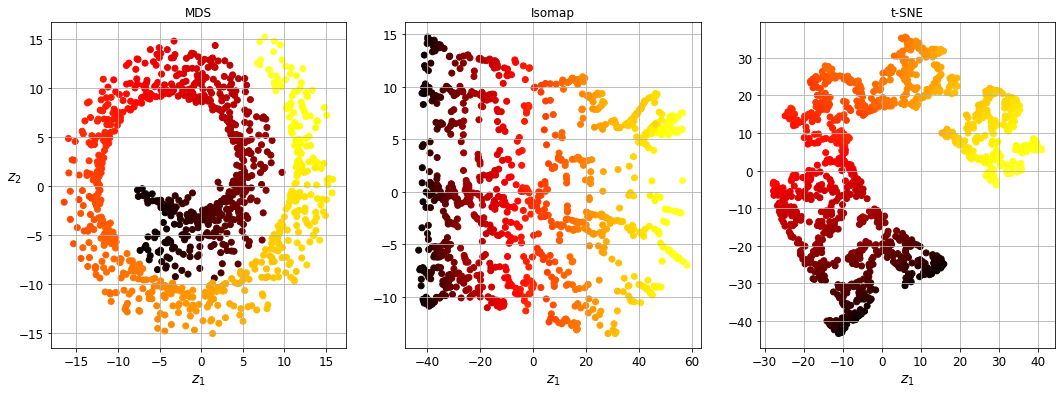

In [42]:
# the following figure shows the result of a few of these technique when reducing the dimension of the Swiss roll dataset down to 2D

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(18, 6))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)